# MNIST Image Classification with TensorFlow on Cloud AI Platform

This notebook demonstrates how to implement different image models on MNIST using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Learning Objectives
1. Understand how to build a Dense Neural Network (DNN) for image classification
2. Understand how to use dropout (DNN) for image classification
3. Understand how to use Convolutional Neural Networks (CNN)
4. Know how to deploy and use an image classifcation model using Google Cloud's [AI Platform](https://cloud.google.com/ai-platform/)

First things first. Configure the parameters below to match your own Google Cloud project details.

In [ ]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [1]:
from datetime import datetime
import os

PROJECT = "qwiklabs-gcp-00-192ed2cbc8d2"  # REPLACE WITH YOUR PROJECT ID
BUCKET = "qwiklabs-gcp-00-192ed2cbc8d2"  # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1"  # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE = "cnn"  # "linear", "dnn", "dnn_dropout", or "dnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "2.1"  # Tensorflow  version
os.environ["IMAGE_URI"] = os.path.join("gcr.io", PROJECT, "mnist_models")

## Building a dynamic model

In the previous notebook, <a href="mnist_linear.ipynb">mnist_linear.ipynb</a>, we ran our code directly from the notebook. In order to run it on the AI Platform, it needs to be packaged as a python module.

The boilerplate structure for this module has already been set up in the folder `mnist_models`. The module lives in the sub-folder, `trainer`, and is designated as a python package with the empty `__init__.py` (`mnist_models/trainer/__init__.py`) file. It still needs the model and a trainer to run it, so let's make them.

Let's start with the trainer file first. This file parses command line arguments to feed into the model.

In [3]:
%%writefile mnist_models/trainer/task.py
import argparse
import json
import os
import sys

from . import model


def _parse_arguments(argv):
    """Parses command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--model_type',
        help='Which model type to use',
        type=str, default='linear')
    parser.add_argument(
        '--epochs',
        help='The number of epochs to train',
        type=int, default=50)
    parser.add_argument(
        '--steps_per_epoch',
        help='The number of steps per epoch to train',
        type=int, default=100)
    parser.add_argument(
        '--job-dir',
        help='Directory where to save the given model',
        type=str, default='mnist_models/')
    return parser.parse_known_args(argv)


def main():
    """Parses command line arguments and kicks off model training."""
    args = _parse_arguments(sys.argv[1:])[0]

    # Configure path for hyperparameter tuning.
    trial_id = json.loads(
        os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', '')
    output_path = args.job_dir if not trial_id else args.job_dir + '/'

    model_layers = model.get_layers(args.model_type)
    image_model = model.build_model(model_layers, args.job_dir)
    model_history = model.train_and_evaluate(
        image_model, args.epochs, args.steps_per_epoch, args.job_dir)


if __name__ == '__main__':
    main()


Overwriting mnist_models/trainer/task.py


Next, let's group non-model functions into a util file to keep the model file simple. We'll copy over the `scale` and `load_dataset` functions from the previous lab.

In [4]:
%%writefile mnist_models/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclasses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclasses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset


Writing mnist_models/trainer/util.py


Finally, let's code the models! The [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras) accepts an array of [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) into a [model object](https://www.tensorflow.org/api_docs/python/tf/keras/Model), so we can create a dictionary of layers based on the different model types we want to use. The below file has two functions: `get_layers` and `create_and_train_model`. We will build the structure of our model in `get_layers`. Last but not least, we'll copy over the training code from the previous lab into `train_and_evaluate`.

**TODO 1**: Define the Keras layers for a DNN model   
**TODO 2**: Define the Keras layers for a dropout model  
**TODO 3**: Define the Keras layers for a CNN model  

Hint: These models progressively build on each other. Look at the imported `tensorflow.keras.layers` modules and the default values for the variables defined in `get_layers` for guidance.

In [6]:
%%writefile mnist_models/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

from . import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=400,
        hidden_layer_2_neurons=100,
        dropout_rate=0.25,
        num_filters_1=64,
        kernel_size_1=3,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        'dnn': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        'dnn_dropout': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        'cnn': [
            Conv2D(num_filters_1, kernel_size=kernel_size_1,
                   activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2,
                   activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.fashion_mnist.load_data()
    train_data = util.load_dataset(mnist)
    validation_data = util.load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history


Overwriting mnist_models/trainer/model.py


## Local Training

With everything set up, let's run locally to test the code. Some of the previous tests have been copied over into a testing script `mnist_models/trainer/test.py` to make sure the model still passes our previous checks. On `line 13`, you can specify which model types you would like to check. `line 14` and `line 15` has the number of epochs and steps per epoch respectively.

Moment of truth! Run the code below to check your models against the unit tests. If you see "OK" at the end when it's finished running, congrats! You've passed the tests!

In [10]:
!python3 -m mnist_models.trainer.test

2020-11-11 12:20:51.565979: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200135000 Hz
2020-11-11 12:20:51.566432: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557b9731a750 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-11 12:20:51.566473: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-11 12:20:51.566663: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
.2020-11-11 12:21:02.161585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 1359 of 5000
2020-11-11 12:21:04.615772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:221] Shuffle buffer filled.
.
*** Building model for linear ***

Epoch 1/30
100/100 - 2s - loss: 1.1208 - accuracy: 0.6371 - va

Now that we know that our models are working as expected, let's run it on the [Google Cloud AI Platform](https://cloud.google.com/ml-engine/docs/). We can run it as a python module locally first using the command line.

The below cell transfers some of our variables to the command line as well as create a job directory including a timestamp.

In [11]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "mnist_models/models/{}_{}/".format(
    model_type, current_time)

The cell below runs the local version of the code. The epochs and steps_per_epoch flag can be changed to run for longer or shorther, as defined in our `mnist_models/trainer/task.py` file.

In [14]:
%%bash
python3 -m mnist_models.trainer.task \
    --job-dir=$JOB_DIR \
    --epochs=50 \
    --steps_per_epoch=50 \
    --model_type=$MODEL_TYPE

Epoch 1/50
50/50 - 6s - loss: 1.2688 - accuracy: 0.5398 - val_loss: 0.8119 - val_accuracy: 0.6907
Epoch 2/50
50/50 - 4s - loss: 0.7661 - accuracy: 0.7226 - val_loss: 0.6485 - val_accuracy: 0.7454
Epoch 3/50
50/50 - 5s - loss: 0.6491 - accuracy: 0.7560 - val_loss: 0.5994 - val_accuracy: 0.7737
Epoch 4/50
50/50 - 5s - loss: 0.5833 - accuracy: 0.7836 - val_loss: 0.5282 - val_accuracy: 0.7987
Epoch 5/50
50/50 - 5s - loss: 0.5332 - accuracy: 0.8040 - val_loss: 0.5005 - val_accuracy: 0.8143
Epoch 6/50
50/50 - 5s - loss: 0.5075 - accuracy: 0.8160 - val_loss: 0.4772 - val_accuracy: 0.8276
Epoch 7/50
50/50 - 6s - loss: 0.4995 - accuracy: 0.8174 - val_loss: 0.4687 - val_accuracy: 0.8250
Epoch 8/50
50/50 - 6s - loss: 0.4667 - accuracy: 0.8308 - val_loss: 0.4319 - val_accuracy: 0.8387
Epoch 9/50
50/50 - 6s - loss: 0.4544 - accuracy: 0.8336 - val_loss: 0.4227 - val_accuracy: 0.8446
Epoch 10/50
50/50 - 6s - loss: 0.4378 - accuracy: 0.8352 - val_loss: 0.4202 - val_accuracy: 0.8484
Epoch 11/50
50/50 -

2020-11-11 12:32:47.957867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200135000 Hz
2020-11-11 12:32:47.958131: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ed38566540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-11 12:32:47.958160: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-11 12:32:47.958306: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2020-11-11 12:32:48.523990: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2020-11-11 12:32:59.314417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 1791 of 5000
2020-11-11 12:32:59.376425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:221] Shuffle buffe

## Training on the cloud

Since we're using an unreleased version of TensorFlow on AI Platform, we can instead use a [Deep Learning Container](https://cloud.google.com/ai-platform/deep-learning-containers/docs/overview) in order to take advantage of libraries and applications not normally packaged with AI Platform. Below is a simple [Dockerlife](https://docs.docker.com/engine/reference/builder/) which copies our code to be used in a TF2 environment.

In [15]:
%%writefile mnist_models/Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-cpu
COPY mnist_models/trainer /mnist_models/trainer
ENTRYPOINT ["python3", "-m", "mnist_models.trainer.task"]

Writing mnist_models/Dockerfile


The below command builds the image and ships it off to Google Cloud so it can be used for AI Platform. When built, it will show up [here](http://console.cloud.google.com/gcr) with the name `mnist_models`. ([Click here](https://console.cloud.google.com/cloud-build) to enable Cloud Build)

In [16]:
!docker build -f mnist_models/Dockerfile -t $IMAGE_URI ./

Sending build context to Docker daemon  11.22MB
Step 1/3 : FROM gcr.io/deeplearning-platform-release/tf2-cpu
latest: Pulling from deeplearning-platform-release/tf2-cpu

57c49d0f: Pulling fs layer 
40447d26: Pulling fs layer 
2f862619: Pulling fs layer 
1f3e34a5: Pulling fs layer 
b1d84ca2: Pulling fs layer 
56ff8380: Pulling fs layer 
1120baa8: Pulling fs layer 
e7454557: Pulling fs layer 
675fffbf: Pulling fs layer 
d61a5409: Pulling fs layer 
fbc05d66: Pulling fs layer 
b1d84ca2: Waiting fs layer 
f3e34a5: Waiting fs layer 
56ff8380: Waiting fs layer 
d8953b28: Pulling fs layer 
eb893087: Pulling fs layer 
2d981bd7: Pulling fs layer 
24ed0738: Pulling fs layer 
Digest: sha256:856b92e4e129f8d0b35c01bb246a971a51425574d3735e36168738ab70ff1e9a2K
Status: Downloaded newer image for gcr.io/deeplearning-platform-release/tf2-cpu:latest
 ---> 5da86de06f21
Step 2/3 : COPY mnist_models/trainer /mnist_models/trainer
 ---> f227b7bae2e7
Step 3/3 : ENTRYPOINT ["python3", "-m", "mnist_models.trainer.

In [18]:
!docker push $IMAGE_URI

The push refers to repository [gcr.io/qwiklabs-gcp-00-192ed2cbc8d2/mnist_models]

95d461e5: Preparing 
f5329ffe: Preparing 
65862d12: Preparing 
914efb9d: Preparing 
8d3b5450: Preparing 
650f3987: Preparing 
bb4f1a00: Preparing 
f2367cb1: Preparing 
f4525b18: Preparing 
6bc8336a: Preparing 
1a4e77da: Preparing 
a23e773b: Preparing 
6dd12977: Preparing 
8cd296e7: Preparing 
bb4f1a00: Waiting g 
50f3987: Waiting g 
707a345d: Preparing 
4df0ad6c: Preparing 
2367cb1: Waiting g 
02706667: Layer already exists latest: digest: sha256:4cf0dc7de1ab6abad54698224f6aed453bc02f7999ea71c0e37bfd1bd16646ea size: 4504


Finally, we can kickoff the [AI Platform training job](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training). We can pass in our docker image using the `master-image-uri` flag.

In [19]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "gs://{}/mnist_{}_{}/".format(
    BUCKET, model_type, current_time)
os.environ["JOB_NAME"] = "mnist_{}_{}".format(
    model_type, current_time)

In [20]:
%%bash
echo $JOB_DIR $REGION $JOB_NAME
gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket=gs://$BUCKET \
    --region=$REGION \
    --master-image-uri=$IMAGE_URI \
    --scale-tier=BASIC_GPU \
    --job-dir=$JOB_DIR \
    -- \
    --model_type=$MODEL_TYPE

gs://qwiklabs-gcp-00-192ed2cbc8d2/mnist_cnn_201111_125303/ us-central1 mnist_cnn_201111_125303
jobId: mnist_cnn_201111_125303
state: QUEUED


Job [mnist_cnn_201111_125303] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mnist_cnn_201111_125303

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mnist_cnn_201111_125303


Can't wait to see the results? Run the code below and copy the output into the [Google Cloud Shell](https://console.cloud.google.com/home/dashboard?cloudshell=true) to follow.

## Deploying and predicting with model

Once you have a model you're proud of, let's deploy it! All we need to do is give AI Platform the location of the model. Below uses the keras export path of the previous job, but `${JOB_DIR}keras_export/` can always be changed to a different path.

Uncomment the delete commands below if you are getting an "already exists error" and want to deploy a new model.

In [21]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=${JOB_DIR}keras_export/
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#yes | gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#yes | gcloud ai-platform models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} \
    --model ${MODEL_NAME} \
    --origin ${MODEL_LOCATION} \
    --framework tensorflow \
    --runtime-version=2.1

Deleting and deploying mnist cnn from gs://qwiklabs-gcp-00-192ed2cbc8d2/mnist_cnn_201111_125303/keras_export/ ... this will take a few minutes


Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/qwiklabs-gcp-00-192ed2cbc8d2/models/mnist].
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

To predict with the model, let's take one of the example images.

**TODO 4**: Write a `.json` file with image data to send to an AI Platform deployed model

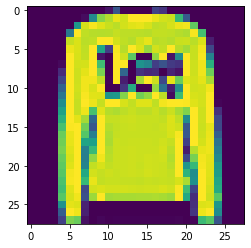

In [25]:
import json, codecs
import tensorflow as tf
import matplotlib.pyplot as plt
from mnist_models.trainer import util

HEIGHT = 28
WIDTH = 28
IMGNO = 1

mnist = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO]

jsondata = test_image.reshape(HEIGHT, WIDTH, 1).tolist()
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
plt.imshow(test_image.reshape(HEIGHT, WIDTH));

Finally, we can send it to the prediction service. The output will have a 1 in the index of the corresponding digit it is predicting. Congrats! You've completed the lab!

In [26]:
%%bash
gcloud ai-platform predict \
    --model=mnist \
    --version=${MODEL_TYPE} \
    --json-instances=./test.json

SOFTMAX_3
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Using endpoint [https://ml.googleapis.com/]


Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.